In [1]:
import scipy.io
import numpy
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stat
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from multiprocessing import Pool
from scipy import stats
import math

In [ ]:
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

# Lineplots first!
## Odd is Accuracy Even is Speed

## 0 1 are sudden

In [2]:
def lineplots(data, block, first, last):
    traj = scipy.io.loadmat('data/data{data}/actual_trajectories/trajectories{block}.mat'.format(block=str(block), data=str(data)))

    for i in range(first,last):
        plt.plot(traj['x'][0][i][0], traj['y'][0][i][0])


In [ ]:
interact(lineplots, data = widgets.ToggleButtons(options = range(1000, 1060)), block = widgets.IntSlider(max = 11, min = 0, value = 0, step = 1),
        first = widgets.IntSlider(max = 63, min = 0, value = 0, step = 1), last = widgets.IntSlider(max = 64, min = 1, value = 1, step = 1))

## Error Vs Time plots

Divide Trajectories by 5. Calculate mean and standard deviation of difference between ideal and actual trajectories (both divided by 5) for all 64 trajectories in a block. 
From the movement time, calculate how long it took to finish each of these 5 trajectories. Calculate mean and standard deviation across 64 trials. 

This might as well just be equal to the mean and standard deviation of the **number** of points in each of those five quantiles for all trajectories.



# Error Calculation
Takes in a trajectory loaded from the mat file and calculates error by comparing minimum distance from x and y coordinates of the actual trajectory to the ideal trajectory

In [2]:
#square_coord = scipy.io.loadmat('data/pilot/pilot_1/squares/coordinates/squares3.mat')
#traj = scipy.io.loadmat('data/pilot/pilot_1/actual_trajectories/trajectories3.mat')
#def calc_error(traj, square_coord):
# The version above uses square coordinates
def calc_error(traj):    
    error = list()
    for j in range(64):
        traj_dist = list()
        trajx, trajy = traj['x'][0][j][0], traj['y'][0][j][0]
        #end_pointx, end_pointy  = square_coord['squareX'][0][j], square_coord['squareY'][0][j]
        end_pointx, end_pointy  = traj['x'][0][j][0][-1], traj['y'][0][j][0][-1]

        xline = numpy.linspace(0, end_pointx, 500)
        yline = numpy.linspace(0, end_pointy, 500)

        for i in range(len(trajx)):
            xdist = min(numpy.absolute(xline-trajx[i]))
            ydist = min(numpy.absolute(yline-trajy[i]))
            dist = numpy.sqrt(xdist**2 + ydist**2)
            traj_dist.append(dist)
        error.append(traj_dist)
    return error
#dist = numpy.linalg.norm(numpy.cross(p2-p1, p1-p3))/numpy.linalg.norm(p2-p1)

In [ ]:
#traj['x'][0][0][0][-1]

In [ ]:
#calc_error(traj, square_coord)

Participant 1 Gradual Change Accuracy emphasis

Participant 2 Sudden change Accuracy emphasis

Participant 3 Gradual change Speed emphasis

# Time quintiles:
X axis is cummulative sum of the number of samples in the trajectory, averaged across all trajectories. 
Y axis is the mean of error in that time quantile, averaged across all trajectories


In [3]:
def errorvstime(data, block, num_trajectories):
    traj = scipy.io.loadmat('data/data{data}/actual_trajectories/trajectories{block}.mat'.format(block=str(block), data=str(data)))
    ideal_traj = scipy.io.loadmat('data/data{data}/ideal_trajectories/trajectories{block}.mat'.format(block = str(block), data=str(data)))
    #squares = scipy.io.loadmat('data/participants/data{data}/squares/coordinates/squares{block}.mat'.format(block=str(block), data=str(data)))
    #xdiff = (ideal_traj['idealXs'] - traj['x'])
    #ydiff = (ideal_traj['idealYs'] - traj['y'])
    error = calc_error(traj)[:num_trajectories]
    #error = xdiff**2+ydiff**2
    #print (error)
    error_means = numpy.zeros((num_trajectories, 5))
    for i in range(num_trajectories):
        n = len(error[i])
        for j in range(5):
            error_means[i, j] = numpy.mean(error[i][int(numpy.floor((j)*n/5)):int(numpy.floor((j+1)*n/5))])
#            error_means[i, j] = numpy.median(error[i][int(numpy.floor((j)*n/5)):int(numpy.floor((j+1)*n/5))])
         #error_means[i, ] = error_means[i, ]/max(error_means[i,])

    
    time_means = numpy.zeros((num_trajectories, 5))

    for i in range(num_trajectories):
        n = len(error[i])
        for j in range(5):
            time_means[i, j] = len(error[i][int(numpy.floor((j)*n/5)):int(numpy.floor((j+1)*n/5))])
    times = numpy.cumsum(numpy.mean(time_means, axis = 0))
    plt.errorbar(times, numpy.mean(error_means, axis = 0), xerr = stat.sem(time_means, axis = 0), yerr = stat.sem(error_means, axis = 0))
    plt.ylabel('Error')
    plt.xlabel('Time')
    plt.xlim(0, 100)
    plt.ylim(-20, 70)
    return times, numpy.mean(error_means, axis = 0)

Calculate error vs time for each block collapsed across participants.

C:\Users\Tejas\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Tejas\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


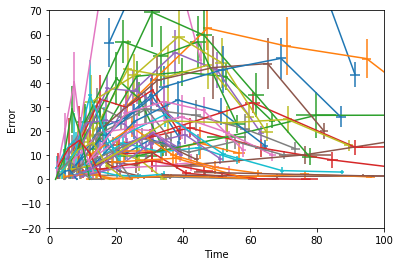

In [6]:
times = numpy.zeros((60, 5))
errors = numpy.zeros((60, 5))
for i in range(1000, 1059):
    temp = errorvstime(i, 11, 32)
    times[i-1000] = temp[0]
    errors[i-1000] = temp[1] 
    #print (i)

In [7]:
times_speed_sudden = numpy.zeros((60, 5))
times_speed_gradual = numpy.zeros((60, 5))
times_accuracy_sudden = numpy.zeros((60, 5))
times_accuracy_gradual = numpy.zeros((60, 5))
errors_speed_sudden = numpy.zeros((60, 5))
errors_speed_gradual = numpy.zeros((60, 5))
errors_accuracy_sudden = numpy.zeros((60, 5))
errors_accuracy_gradual = numpy.zeros((60, 5))
for i in range(len(times)):
    if i%4 == 0:
        times_speed_sudden[i] = times[i]
        errors_speed_sudden[i] = errors[i]
    elif i%4 == 1:
        times_accuracy_sudden[i] = times[i]
        errors_accuracy_sudden[i] = errors[i]
    elif i%4 == 2:
        times_speed_gradual[i] = times[i]
        errors_speed_gradual[i] = errors[i]
    elif i%4 == 3:
        times_accuracy_gradual[i] = times[i]
        errors_accuracy_gradual[i] = errors[i]
       

In [8]:
times_speed_gradual = numpy.reshape(times_speed_gradual[numpy.nonzero(times_speed_gradual)], (int(len(times_speed_gradual[numpy.nonzero(times_speed_gradual)])/5), 5))
errors_speed_gradual = numpy.reshape(errors_speed_gradual[numpy.nonzero(errors_speed_gradual)], (int(len(errors_speed_gradual[numpy.nonzero(errors_speed_gradual)])/5), 5))
times_speed_sudden = numpy.reshape(times_speed_sudden[numpy.nonzero(times_speed_sudden)], (int(len(times_speed_sudden[numpy.nonzero(times_speed_sudden)])/5), 5))
errors_speed_sudden = numpy.reshape(errors_speed_sudden[numpy.nonzero(errors_speed_sudden)], (int(len(errors_speed_sudden[numpy.nonzero(errors_speed_sudden)])/5), 5))
times_accuracy_gradual = numpy.reshape(times_accuracy_gradual[numpy.nonzero(times_accuracy_gradual)], (int(len(times_accuracy_gradual[numpy.nonzero(times_accuracy_gradual)])/5), 5))
errors_accuracy_gradual = numpy.reshape(errors_accuracy_gradual[numpy.nonzero(errors_accuracy_gradual)], (int(len(errors_accuracy_gradual[numpy.nonzero(errors_accuracy_gradual)])/5), 5))
times_accuracy_sudden = numpy.reshape(times_accuracy_sudden[numpy.nonzero(times_accuracy_sudden)], (int(len(times_accuracy_sudden[numpy.nonzero(times_accuracy_sudden)])/5), 5))
errors_accuracy_sudden = numpy.reshape(errors_accuracy_sudden[numpy.nonzero(errors_accuracy_sudden)], (int(len(errors_accuracy_sudden[numpy.nonzero(errors_accuracy_sudden)])/5), 5))


In [ ]:
times_speed_sudden

In [ ]:
#numpy.mean(times_accuracy_gradual, axis = 0)
#numpy.nanmean(errors_speed_sudden, axis = 0)
#stat.sem(times_accuracy_gradual, axis = 0)
#numpy.nanstd(errors_accuracy_gradual, axis = 0)/numpy.sqrt(errors_accuracy_gradual)
#numpy.nanstd(errors_accuracy_gradual)

numpy.shape(numpy.nonzero(times_accuracy_sudden))

Text(0, 0.5, 'Error')

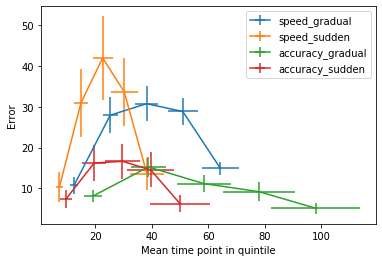

In [9]:
fig,(ax1)=plt.subplots(1,1)
ax1.errorbar(numpy.nanmean(times_speed_gradual, axis = 0), numpy.nanmean(errors_speed_gradual, axis = 0), xerr=stat.sem(times_speed_gradual, axis = 0), yerr=numpy.nanstd(errors_speed_gradual, axis = 0)/numpy.sqrt(len(errors_speed_gradual)), label = "speed_gradual")
ax1.errorbar(numpy.nanmean(times_speed_sudden, axis = 0), numpy.nanmean(errors_speed_sudden, axis = 0), xerr=stat.sem(times_speed_sudden, axis = 0), yerr=numpy.nanstd(errors_speed_sudden, axis = 0)/numpy.sqrt(len(errors_speed_sudden)), label = "speed_sudden")
ax1.errorbar(numpy.nanmean(times_accuracy_gradual, axis = 0), numpy.nanmean(errors_accuracy_gradual, axis = 0), xerr=stat.sem(times_accuracy_gradual, axis = 0), yerr=numpy.nanstd(errors_accuracy_gradual, axis = 0)/numpy.sqrt(len(errors_accuracy_gradual)), label = "accuracy_gradual")
ax1.errorbar(numpy.nanmean(times_accuracy_sudden, axis = 0), numpy.nanmean(errors_accuracy_sudden, axis = 0), xerr=stat.sem(times_accuracy_sudden, axis = 0), yerr=numpy.nanstd(errors_accuracy_sudden, axis = 0)/numpy.sqrt(len(errors_accuracy_sudden)), label = "accuracy_sudden")
ax1.legend()
plt.xlabel('Mean time point in quintile')
plt.ylabel('Error')


# Time Bar plots

In [ ]:
pos = [0, 1, 2, 3]
handles = plt.bar(pos, [numpy.median(times_speed_gradual), numpy.median(times_accuracy_gradual), numpy.median(times_speed_sudden), numpy.median(times_accuracy_sudden)], yerr = [numpy.mean(stat.sem(times_speed_gradual)), numpy.mean(stat.sem(times_accuracy_gradual)), numpy.mean(stat.sem(times_speed_sudden)), numpy.mean(stat.sem(times_accuracy_sudden))], color = ['Blue', 'Green', 'Blue', 'Green'], capsize = 3)
plt.xticks([0.5, 2.5], ['Gradual', 'Sudden'])
plt.ylabel('Times')
plt.xlabel('Condition')

plt.legend([handles[0], handles[1]], ['Speed', 'Accuracy'])
#handles[0]

In [ ]:
numpy.ravel(times_accuracy_gradual)

In [ ]:
pos = [1, 2]
yerr = [numpy.mean(stat.sem(numpy.concatenate((times_speed_gradual, times_accuracy_gradual)))), numpy.mean(stat.sem(numpy.concatenate((times_speed_sudden, times_accuracy_sudden))))]
plt.bar(pos, [numpy.mean(numpy.concatenate((times_speed_gradual, times_accuracy_gradual))), numpy.mean(numpy.concatenate((times_speed_sudden, times_accuracy_sudden)))], yerr = yerr, color = 'blue')
plt.xticks(pos, ['Gradual', 'Sudden'])
plt.ylabel('Times')
plt.xlabel('Condition')


In [ ]:
pos = [0, 1]
yerr = [numpy.mean(stat.sem(numpy.concatenate((times_speed_gradual, times_speed_sudden)))), numpy.mean(stat.sem(numpy.concatenate((times_accuracy_gradual, times_accuracy_sudden))))]
plt.bar(pos, [numpy.mean(numpy.concatenate((times_speed_gradual, times_speed_sudden))), numpy.mean(numpy.concatenate((times_accuracy_gradual, times_accuracy_sudden)))], yerr = yerr)
plt.xticks(pos, ['Speed', 'Accuracy'])
plt.ylabel('Times')
plt.xlabel('Condition')


# Error Bar plots

In [ ]:
errors_accuracy_gradual

In [ ]:
#path = 'C:/Users/Tejas/OneDrive/Research/Conferences and Papers/Psychonomics 2019/errors/'
#plt.rcParams[('figure.figsize')] = [8, 6]
pos = [0, 1, 2, 3]
y = [numpy.nanmean(errors_accuracy_sudden),
    numpy.nanmean(errors_speed_sudden),
    numpy.nanmean(errors_accuracy_gradual),
     numpy.nanmean(errors_speed_gradual)
    ]
y_sem = [numpy.mean(stat.sem(times_accuracy_sudden)),
        numpy.mean(stat.sem(times_speed_sudden)),
        numpy.mean(stat.sem(times_accuracy_gradual)),
        numpy.mean(stat.sem(times_speed_gradual))]
#handles = plt.bar(pos, yerr = [numpy.mean(stat.sem(times_speed_gradual)), numpy.nanmean(stat.sem(errors_accuracy_gradual)), numpy.nanmean(stat.sem(times_speed_sudden)), numpy.mean(stat.sem(times_accuracy_sudden))], color = ['Blue', 'Green', 'Blue', 'Green'])
plt.bar(0, y[0], yerr = y_sem[0], capsize = 3, color = 'Blue', alpha = 1)
plt.bar(2, y[1], yerr = y_sem[1], capsize = 3, color = 'Blue', alpha = 0.5)
plt.bar(1, y[2], yerr = y_sem[2], capsize = 3, color = 'Green', alpha = 1)
plt.bar(3, y[3], yerr = y_sem[3], capsize = 3, color = 'Green', alpha = 0.5)

plt.xticks([0, 2, 1, 3], ['Sudden \n Accuracy', 'Sudden \n Speed', 'Gradual \n Accuracy', 'Gradual \nSpeed'], rotation = 'vertical')
plt.ylabel('RMSE')
plt.xlabel('Condition')
#plt.legend([handles[0], handles[1]], ['Speed', 'Accuracy'])
plt.title('Error')
#plt.tight_layout()
#plt.savefig(path+'transfer.png', dpi = 300)


In [ ]:
yerr = [numpy.nanmean(stat.sem(numpy.concatenate((errors_speed_gradual, errors_speed_sudden)))), numpy.nanmean(stat.sem(numpy.concatenate((errors_accuracy_gradual, errors_accuracy_sudden))))]
plt.bar(['Speed', 'Accuracy'], [numpy.nanmean(numpy.concatenate((errors_speed_gradual, errors_speed_sudden))), numpy.nanmean(numpy.concatenate((errors_accuracy_gradual, errors_accuracy_sudden)))], yerr = yerr)
plt.xlabel('Emphasis')
plt.ylabel('Error')
print (yerr)

In [ ]:
yerr = [numpy.nanmean(stat.sem(numpy.concatenate((errors_speed_gradual, errors_accuracy_gradual)))), numpy.nanmean(stat.sem(numpy.concatenate((errors_speed_sudden, errors_accuracy_sudden))))]
plt.bar(['Gradual', 'Sudden'], [numpy.nanmean(numpy.concatenate((errors_speed_gradual, errors_accuracy_gradual))), numpy.nanmean(numpy.concatenate((errors_speed_sudden, errors_accuracy_sudden)))], yerr = yerr)
plt.xlabel('Condition')
plt.ylabel('Error')
print (yerr)

In [ ]:
interact(errorvstime, data = widgets.ToggleButtons(options = range(1,27)), 
                      block = widgets.IntSlider(max = 11, min = 0, value = 0, step = 1))

Likelihood of the data

Boundary is how good my plan is. Boundary affected by speed/accuracy.

Drift rate affected by gradual vs sudden.

In [4]:
def errors(data, block):
    traj = scipy.io.loadmat('data/data{data}/actual_trajectories/trajectories{block}.mat'.format(block=str(block), data=str(data)))
    ideal_traj = scipy.io.loadmat('data/data{data}/ideal_trajectories/trajectories{block}.mat'.format(block = str(block), data=str(data)))
    #print (traj)
    #squares = scipy.io.loadmat('data/participants/data{data}/squares/coordinates/squares{block}.mat'.format(block=str(block), data=str(data)))
    #xdiff = (ideal_traj['idealXs'] - traj['x'])
    #ydiff = (ideal_traj['idealYs'] - traj['y'])
    error = calc_error(traj)
    return numpy.array(error)

In [ ]:
temp = errors(1, 1)

In [5]:
def all_errors(num_participants, num_blocks, num_trajectories):
    error_sum = numpy.zeros((num_participants, num_blocks, num_trajectories))
    error_std = numpy.zeros((num_participants, num_blocks, num_trajectories))
    for participant in range(num_participants):
        for block in range(num_blocks):
            temp = errors(participant+1000, block)
            for trial in range(num_trajectories):
                error_sum[participant, block, trial] = numpy.nanmean(temp[trial])
                error_std[participant, block, trial] = stat.sem(temp[trial])
        print (participant)
            #error_sum1.append(numpy.mean(numpy.sum(errors(1, block), axis=0)))
            #error_std1.append(numpy.std(numpy.sum(errors(1, block), axis=0)))
            #error_sum2.append(numpy.mean(numpy.sum(errors(2, block), axis=0)))
            #error_std2.append(numpy.std(numpy.sum(errors(2, block), axis=0)))
            #error_sum3.append(numpy.mean(numpy.sum(errors(3, block), axis=0)))
            #error_std3.append(numpy.std(numpy.sum(errors(3, block), axis=0)))    
    return error_sum, error_std

In [10]:
error_sum, error_std = all_errors(60, 12, 16)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


In [ ]:
plt.plot(numpy.mean((error_sum[1:-1:2]), axis = 0), 'k-')
plt.plot(numpy.mean((error_sum[2:-1:2]), axis = 0), 'k-')

plot1 = plt.fill_between(range(12), numpy.mean(error_sum[1:-1:2], axis = 0) + stat.sem(error_sum[1:-1:2]), numpy.mean(error_sum[1:-1:2], axis = 0) - stat.sem(error_sum[1:-1:2]), alpha = 0.5)
plot2 = plt.fill_between(range(12), numpy.mean(error_sum[2:-1:2], axis = 0) + stat.sem(error_sum[2:-1:2]), numpy.mean(error_sum[2:-1:2], axis = 0) - stat.sem(error_sum[2:-1:2]), alpha = 0.5)
plt.legend((plot1, plot2), ("Accuracy", "Speed"))
#error_sum[3]
#error_sum1
plt.xlabel('Block')
plt.ylabel('Error')

In [11]:
def plot_error_means(errors, path):
    #plt.rcParams[('figure.figsize')] = [8, 6]

    mean_errors = numpy.mean(error_sum, axis =2)
    plt.errorbar(range(1, 11), numpy.mean(numpy.mean(error_sum, axis = 2)[3::4], axis = 0)[1:-1], yerr = stat.sem(numpy.mean(error_sum, axis = 2)[1::4], axis = 0)[1:-1], capsize=3)
    plt.errorbar(0, numpy.mean(numpy.mean(error_sum, axis = 2)[3::4], axis = 0)[0], yerr = stat.sem(numpy.mean(error_sum, axis = 2)[3::4], axis = 0)[0], capsize=3, fmt = 's')
    plt.errorbar(11, numpy.mean(numpy.mean(error_sum, axis = 2)[3::4], axis = 0)[11], yerr = stat.sem(numpy.mean(error_sum, axis = 2)[3::4], axis = 0)[11], capsize=3, fmt = 's')
    plt.text(x=5, y = 80, s = '14 Participants')
    plt.ylabel('RMSE')
    plt.xlabel('Block')
    plt.title('Gradual Accuracy')
    plt.xticks(range(12), ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'])

    #y_lim_max = numpy.max((mean_errors)) + 5
    y_lim_max = 100
    plt.ylim((0, y_lim_max))
#    print(max(np.mean(quantiles[3::4][:, :, 3], axis = 0)[1:-1]) + 0.7)
    #plt.tight_layout()
    #plt.savefig(path+'learning_GA.png', dpi = 600)
    plt.show()

    plt.errorbar(range(1, 11), numpy.mean(numpy.mean(error_sum, axis = 2)[2::4], axis = 0)[1:-1], yerr = stat.sem(numpy.mean(error_sum, axis = 2)[2::4], axis = 0)[1:-1], capsize=3)
    plt.errorbar(0, numpy.mean(numpy.mean(error_sum, axis = 2)[2::4], axis = 0)[0], yerr = stat.sem(numpy.mean(error_sum, axis = 2)[2::4], axis = 0)[0], capsize=3, fmt = 's')
    plt.errorbar(11, numpy.mean(numpy.mean(error_sum, axis = 2)[2::4], axis = 0)[11], yerr = stat.sem(numpy.mean(error_sum, axis = 2)[2::4], axis = 0)[11], capsize=3, fmt = 's')
    plt.text(x=5, y = 80, s = '15 Participants')
    plt.ylabel('RMSE')
    plt.xlabel('Block')
    plt.xticks(range(12), ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'])
    plt.title('Gradual Speed')
    plt.ylim(2, y_lim_max)
    #plt.tight_layout()
    #plt.savefig(path+'learning_GS.png', dpi = 600)
    plt.show()
    #y_lim_max = 2200

    plt.errorbar(range(1, 11), numpy.mean(numpy.mean(error_sum, axis = 2)[1::4], axis = 0)[1:-1], yerr = stat.sem(numpy.mean(error_sum, axis = 2)[1::4], axis = 0)[1:-1], capsize=3)
    plt.errorbar(0, numpy.mean(numpy.mean(error_sum, axis = 2)[1::4], axis = 0)[0], yerr = stat.sem(numpy.mean(error_sum, axis = 2)[1::4], axis = 0)[0], capsize=3, fmt = 's')
    plt.errorbar(11, numpy.mean(numpy.mean(error_sum, axis = 2)[1::4], axis = 0)[11], yerr = stat.sem(numpy.mean(error_sum, axis = 2)[1::4], axis = 0)[11], capsize=3, fmt = 's')
    plt.text(x=5, y = 80, s = '15 Participants')
    plt.ylabel('RMSE')
    plt.xlabel('Block')
    plt.xticks(range(12), ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'])
    plt.title('Sudden Accuracy')
    #y_lim_max = 10000

    plt.ylim(2, y_lim_max)
    #plt.tight_layout()
    #plt.savefig(path+'learning_SA.png', dpi = 600)
    plt.show()

    plt.errorbar(range(1, 11), numpy.mean(numpy.mean(error_sum, axis = 2)[4::4], axis = 0)[1:-1], yerr = stat.sem(numpy.mean(error_sum, axis = 2)[4::4], axis = 0)[1:-1], capsize=3)
    plt.errorbar(0, numpy.mean(numpy.mean(error_sum, axis = 2)[4::4], axis = 0)[0], yerr = stat.sem(numpy.mean(error_sum, axis = 2)[4::4], axis = 0)[0], capsize=3, fmt = 's')
    plt.errorbar(11, numpy.mean(numpy.mean(error_sum, axis = 2)[4::4], axis = 0)[11], yerr = stat.sem(numpy.mean(error_sum, axis = 2)[4::4], axis = 0)[11], capsize=3, fmt = 's')
    plt.text(x=5, y = 80, s = '14 Participants')
    plt.xticks(range(12), ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'])
    plt.ylabel('RMSE')
    plt.xlabel('Block')
    plt.title('Sudden Speed')
#    y_lim_max = 2600
    plt.ylim(2, y_lim_max)
    #plt.tight_layout()
    #plt.savefig(path+'learning_SS.png', dpi = 600)
    plt.show()


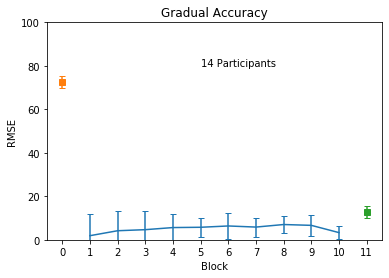

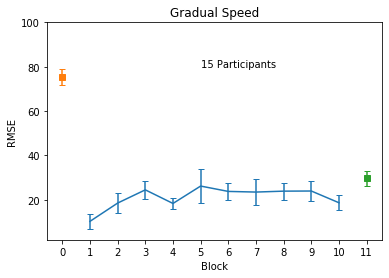

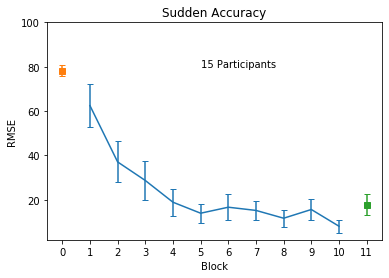

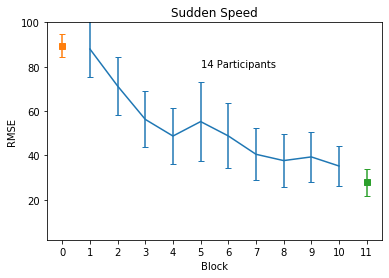

In [12]:
plot_error_means(error_sum, "C:/Users/Tejas/OneDrive/Research/Conferences and Papers/Psychonomics 2019/errors/")

In [13]:
numpy.mean(numpy.mean(error_sum[1::4], axis = 2), axis = 0)
stat.sem(numpy.mean(error_sum[1::4], axis = 2), axis = 0)
def plot_error_means_transfer(errors, text):
#    quantiles = get_quantile(total_times)
    xpos = [0, 1, 2, 3, 4]
    y = numpy.array([numpy.mean(numpy.median(error_sum[1::4], axis = 2), axis = 0)[11],
                  numpy.mean(numpy.mean(error_sum[4::4], axis = 2), axis = 0)[11],
                  numpy.mean(numpy.mean(error_sum[3::4], axis = 2), axis = 0)[11],
                  numpy.mean(numpy.mean(error_sum[2::4], axis = 2), axis = 0)[11]] 
                  )
    y_sem = numpy.array([stat.sem(numpy.mean(error_sum[1::4], axis = 2), axis = 0)[11], 
                    stat.sem(numpy.mean(error_sum[4::4], axis = 2), axis = 0)[11],
                    stat.sem(numpy.mean(error_sum[3::4], axis = 2), axis = 0)[11],
                    stat.sem(numpy.mean(error_sum[2::4], axis = 2), axis = 0)[11]])
    #print (y_sem[0])
    plt.bar(0, y[0], yerr = y_sem[0], capsize = 3, color = 'Blue', alpha = 1)
    plt.bar(2, y[1], yerr = y_sem[1], capsize = 3, color = 'Blue', alpha = 0.5)
    plt.bar(1, y[2], yerr = y_sem[2], capsize = 3, color = 'Green', alpha = 0.5)
    plt.bar(3, y[3], yerr = y_sem[3], capsize = 3, color = 'Green', alpha = 1)

#    handles = plt.bar(range(4), y, yerr = y_sem, capsize = 3, color = ['Blue', 'Green', 'Blue', 'Green'], alpha = [1, 0.5, 0.5, 1])
    plt.xticks([0, 2, 1, 3], ['Sudden \n Accuracy', 'Sudden \n Speed', 'Gradual \n Accuracy', 'Gradual \nSpeed'], rotation = 'vertical')
    plt.ylabel('Error (RMSE)')
    plt.xlabel('Condition')
    #plt.legend([handles[0], handles[1]], ['Speed', 'Accuracy'])
    plt.title(text)
    

#numpy.shape(numpy.mean(error_sum[1::4], axis = 0))

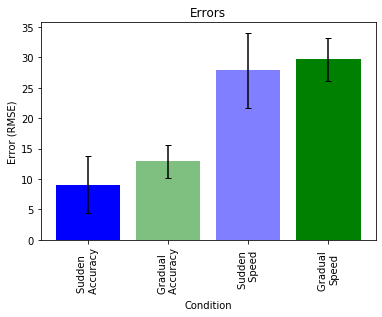

In [14]:
plot_error_means_transfer(error_sum, 'Errors')

In [190]:
data = 10
block = 10
num_trials = 2
traj = scipy.io.loadmat('data/data{data}/actual_trajectories/trajectories{block}.mat'.format(block=str(block), data=str(data+1000)))
for trial in range(num_trials):
    trajx, trajy = traj['x'][0][trial][0], traj['y'][0][trial][0]
    diffx, diffy = trajx[1:] - trajx[:-1], trajy[1:] - trajy[:-1]
    #print (diffx, diffy)

1834.0452849729147

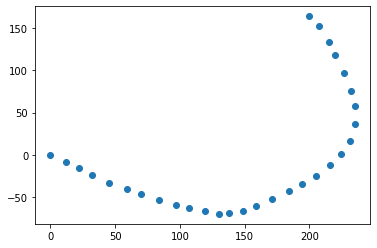

In [195]:
plt.scatter(trajx, trajy)
numpy.sum(numpy.sqrt((numpy.square(diffx, dtype = float) + numpy.square(diffy, dtype = float))))

In [277]:
#Calculate the actual distance travelled in a trajectory.
def calc_dist_travelled(num_data, num_block, num_trials):
    dist = numpy.zeros((num_data, num_block, num_trials))
    for data in range(num_data):
        for block in range(num_block):
            traj = scipy.io.loadmat('data/data{data}/actual_trajectories/trajectories{block}.mat'.format(block=str(block), data=str(data+1000)))
            for trial in range(num_trials):
                trajx, trajy = traj['x'][0][trial][0], traj['y'][0][trial][0]
                diffx, diffy = trajx[1:] - trajx[:-1], trajy[1:] - trajy[:-1]
                #print (diffx, diffy)
                dist[data][block][trial] = numpy.sum(numpy.sqrt((numpy.square(diffx, dtype = float) + numpy.square(diffy, dtype = float))))
    return dist

In [287]:
dist = calc_dist_travelled(60, 12, 32)

In [279]:
def plot_dist_means(distances, path):
    #plt.rcParams[('figure.figsize')] = [8, 6]

    mean_errors = numpy.mean(distances, axis =2)
    plt.errorbar(range(1, 11), numpy.median(numpy.median(distances, axis = 2)[3::4], axis = 0)[1:-1], yerr = stat.sem(numpy.median(distances, axis = 2)[3::4], axis = 0)[1:-1], capsize=3)
    #plt.errorbar(0, numpy.mean(numpy.median(distances, axis = 2)[3::4], axis = 0)[0], yerr = stat.sem(numpy.median(distances, axis = 2)[3::4], axis = 0)[0], capsize=3, fmt = 's')
    plt.errorbar(11, numpy.mean(numpy.median(distances, axis = 2)[3::4], axis = 0)[11], yerr = stat.sem(numpy.median(distances, axis = 2)[3::4], axis = 0)[11], capsize=3, fmt = 's')
    #plt.text(x=5, y = 80, s = '14 Participants')
    plt.ylabel('RMSE')
    plt.xlabel('Block')
    plt.title('Gradual Accuracy')
    plt.xticks(range(12), ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'])

    #y_lim_max = numpy.max((mean_errors)) + 5
    #y_lim_max = 500000
    #plt.ylim((0, y_lim_max))
#    print(max(np.mean(quantiles[3::4][:, :, 3], axis = 0)[1:-1]) + 0.7)
    #plt.tight_layout()
    #plt.savefig(path+'learning_GA.png', dpi = 600)
    plt.show()

    plt.errorbar(range(1, 11), numpy.mean(numpy.median(distances, axis = 2)[2::4], axis = 0)[1:-1], yerr = stat.sem(numpy.median(distances, axis = 2)[2::4], axis = 0)[1:-1], capsize=3)
    #plt.errorbar(0, numpy.mean(numpy.median(distances, axis = 2)[2::4], axis = 0)[0], yerr = stat.sem(numpy.median(distances, axis = 2)[2::4], axis = 0)[0], capsize=3, fmt = 's')
    plt.errorbar(11, numpy.mean(numpy.median(distances, axis = 2)[2::4], axis = 0)[11], yerr = stat.sem(numpy.median(distances, axis = 2)[2::4], axis = 0)[11], capsize=3, fmt = 's')
    #plt.text(x=5, y = 80, s = '15 Participants')
    plt.ylabel('RMSE')
    plt.xlabel('Block')
    plt.xticks(range(12), ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'])
    plt.title('Gradual Speed')
    #plt.ylim(-1, y_lim_max)
    #plt.tight_layout()
    #plt.savefig(path+'learning_GS.png', dpi = 600)
    plt.show()
    #y_lim_max = 2200

    plt.errorbar(range(1, 11), numpy.mean(numpy.median(distances, axis = 2)[1::4], axis = 0)[1:-1], yerr = stat.sem(numpy.median(distances, axis = 2)[1::4], axis = 0)[1:-1], capsize=3)
    #plt.errorbar(0, numpy.mean(numpy.mean(distances, axis = 2)[1::4], axis = 0)[0], yerr = stat.sem(numpy.mean(distances, axis = 2)[1::4], axis = 0)[0], capsize=3, fmt = 's')
    plt.errorbar(11, numpy.mean(numpy.median(distances, axis = 2)[1::4], axis = 0)[11], yerr = stat.sem(numpy.median(distances, axis = 2)[1::4], axis = 0)[11], capsize=3, fmt = 's')
    #plt.text(x=5, y = 80, s = '15 Participants')
    plt.ylabel('RMSE')
    plt.xlabel('Block')
    plt.xticks(range(12), ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'])
    plt.title('Sudden Accuracy')
    #y_lim_max = 10000

    #plt.ylim(2, y_lim_max)
    #plt.tight_layout()
    #plt.savefig(path+'learning_SA.png', dpi = 600)
    plt.show()

    plt.errorbar(range(1, 11), numpy.median(numpy.median(distances, axis = 2)[4::4], axis = 0)[1:-1], yerr = stat.sem(numpy.median(distances, axis = 2)[4::4], axis = 0)[1:-1], capsize=3)
    #plt.errorbar(0, numpy.mean(numpy.median(distances, axis = 2)[4::4], axis = 0)[0], yerr = stat.sem(numpy.median(distances, axis = 2)[4::4], axis = 0)[0], capsize=3, fmt = 's')
    plt.errorbar(11, numpy.mean(numpy.median(distances, axis = 2)[4::4], axis = 0)[11], yerr = stat.sem(numpy.median(distances, axis = 2)[4::4], axis = 0)[11], capsize=3, fmt = 's')
    #plt.text(x=5, y = 80, s = '14 Participants')
    plt.xticks(range(12), ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'])
    plt.ylabel('RMSE')
    plt.xlabel('Block')
    plt.title('Sudden Speed')
#    y_lim_max = 2600
    #plt.ylim(2, y_lim_max)
    #plt.tight_layout()
    #plt.savefig(path+'learning_SS.png', dpi = 600)
    plt.show()


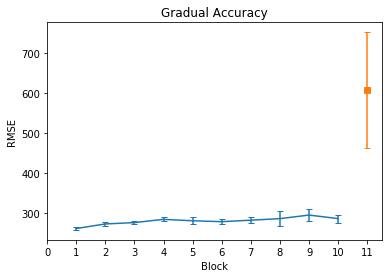

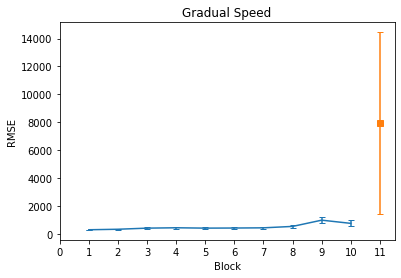

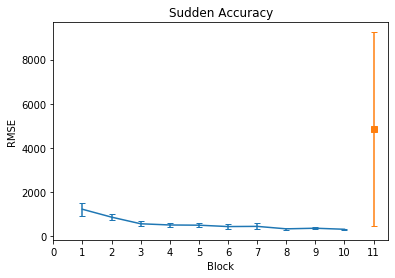

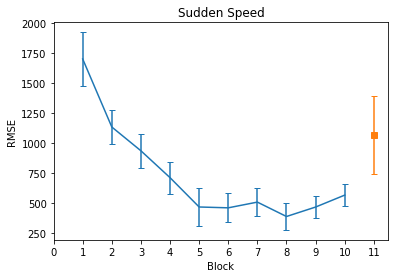

In [280]:
#plt.plot(numpy.mean(numpy.mean(dist[0::4], axis = 2), axis = 0))
#plt.plot(numpy.mean(numpy.mean(dist[1::4], axis = 2), axis = 0))
#plt.plot(numpy.mean(numpy.mean(dist[2::4], axis = 2), axis = 0))
#plt.plot(numpy.mean(numpy.mean(dist[3::4], axis = 2), axis = 0))
plot_dist_means(dist, '')

In [283]:
numpy.mean(numpy.mean(error_sum[1::4], axis = 2), axis = 0)
stat.sem(numpy.mean(error_sum[1::4], axis = 2), axis = 0)
def plot_dist_means_transfer(distances, text):
#    quantiles = get_quantile(total_times)
    xpos = [0, 1, 2, 3, 4]
    y = numpy.array([numpy.mean(numpy.median(distances[1::4], axis = 2), axis = 0)[11],
                  numpy.mean(numpy.median(distances[4::4], axis = 2), axis = 0)[11],
                  numpy.mean(numpy.median(distances[3::4], axis = 2), axis = 0)[11],
                  numpy.mean(numpy.median(distances[2::4], axis = 2), axis = 0)[11]] 
                  )
    y_sem = numpy.array([stat.sem(numpy.median(distances[1::4], axis = 2), axis = 0)[11], 
                    stat.sem(numpy.median(distances[4::4], axis = 2), axis = 0)[11],
                    stat.sem(numpy.median(distances[3::4], axis = 2), axis = 0)[11],
                    stat.sem(numpy.median(distances[2::4], axis = 2), axis = 0)[11]])
    #print (y_sem[0])
    plt.bar(0, y[0], yerr = y_sem[0], capsize = 3, color = 'Blue', alpha = 1)
    plt.bar(2, y[1], yerr = y_sem[1], capsize = 3, color = 'Blue', alpha = 0.5)
    plt.bar(1, y[2], yerr = y_sem[2], capsize = 3, color = 'Green', alpha = 0.5)
    plt.bar(3, y[3], yerr = y_sem[3], capsize = 3, color = 'Green', alpha = 1)

#    handles = plt.bar(range(4), y, yerr = y_sem, capsize = 3, color = ['Blue', 'Green', 'Blue', 'Green'], alpha = [1, 0.5, 0.5, 1])
    plt.xticks([0, 2, 1, 3], ['Sudden \n Accuracy', 'Sudden \n Speed', 'Gradual \n Accuracy', 'Gradual \nSpeed'], rotation = 'vertical')
    plt.ylabel('Error (RMSE)')
    plt.xlabel('Condition')
    #plt.legend([handles[0], handles[1]], ['Speed', 'Accuracy'])
    plt.title(text)
    

#numpy.shape(numpy.mean(error_sum[1::4], axis = 0))

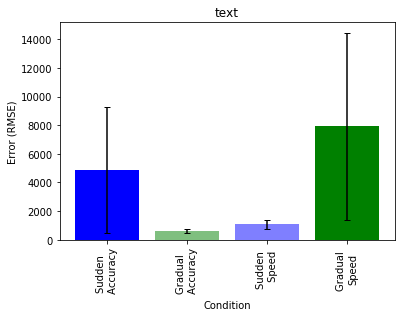

In [288]:
plot_dist_means_transfer(dist, 'text')

In [77]:
numpy.array(diffx, dtype=float)**2

array([9.0000e+02, 1.6900e+02, 1.0000e+02, 8.1000e+01, 1.9600e+02,
       6.4000e+01, 1.2100e+02, 4.9000e+01, 3.6000e+01, 1.6000e+01,
       1.6000e+01, 2.5000e+01, 4.0000e+00, 4.0000e+00, 1.0000e+00,
       0.0000e+00, 1.0000e+00, 1.0000e+00, 4.0000e+00, 1.0000e+00,
       4.0000e+00, 1.0000e+00, 4.0000e+00, 4.0000e+00, 3.6000e+01,
       1.6000e+01, 2.5000e+01, 8.1000e+01, 3.6000e+01, 3.6000e+01,
       8.1000e+01, 2.5000e+01, 3.5344e+04, 1.4400e+02, 1.9600e+02,
       1.4400e+02, 3.2400e+02, 8.1000e+01, 8.1000e+01, 1.4400e+02,
       6.4000e+01, 4.9000e+01, 1.0000e+02, 3.6000e+01, 2.5000e+01,
       3.6000e+01, 4.9000e+01, 1.6000e+01, 4.9000e+01, 1.6000e+01,
       1.6000e+01, 9.0000e+00, 1.6000e+01, 1.6000e+01])

In [74]:
diffx

array([  30,   13,   10,    9,   14,    8,   11,    7,    6,    4,    4,
          5,    2,    2,    1,    0,    1,    1,    2,    1,    2,    1,
          2,    2,    6,    4,    5,    9,    6,    6,    9,    5, -188,
        -12,  -14,  -12,  -18,   -9,   -9,  -12,   -8,   -7,  -10,   -6,
         -5,   -6,   -7,   -4,   -7,   -4,   -4,   -3,   -4,   -4],
      dtype=int16)

In [ ]:
#ybar = [error_sum[2:-1:4] - error_sum[2:-1:4][10], numpy.mean(error_sum[3:-1:4], axis = 0)[11] - numpy.mean(error_sum[3:-1:4], axis = 0)[10], numpy.mean(error_sum[4:-1:4], axis = 0)[11] - numpy.mean(error_sum[4:-1:4], axis = 0)[10], numpy.mean(error_sum[1:-1:4], axis = 0)[11] - numpy.mean(error_sum[1:-1:4], axis = 0)[10]]
y = [error_sum[2:-1:4][:, 11] - error_sum[2:-1:4][:, 10], error_sum[3:-1:4][:, 11] - error_sum[3:-1:4][:, 10], error_sum[4:-1:4][:, 11] - error_sum[4:-1:4][:, 10], error_sum[1:-1:4][:, 11] - error_sum[1:-1:4][:, 10]]
for i in y[3]:
    print (i)


In [ ]:
plt.plot(numpy.mean((error_sum[1:-1:4]), axis = 0), 'k-')
plt.plot(numpy.mean((error_sum[2:-1:4]), axis = 0), 'k-')
plt.plot(numpy.mean((error_sum[3:-1:4]), axis = 0), 'k-')
plt.plot(numpy.mean((error_sum[4:-1:4]), axis = 0), 'k-')

plot1 = plt.fill_between(range(12), numpy.mean(error_sum[1:-1:2], axis = 0) + stat.sem(error_sum[1:-1:2]), numpy.mean(error_sum[1:-1:2], axis = 0) - stat.sem(error_sum[1:-1:2]), alpha = 0.5)
plot2 = plt.fill_between(range(12), numpy.mean(error_sum[2:-1:2], axis = 0) + stat.sem(error_sum[2:-1:2]), numpy.mean(error_sum[2:-1:2], axis = 0) - stat.sem(error_sum[2:-1:2]), alpha = 0.5)
plot3 = plt.fill_between(range(12), numpy.mean(error_sum[3:-1:2], axis = 0) + stat.sem(error_sum[3:-1:2]), numpy.mean(error_sum[3:-1:2], axis = 0) - stat.sem(error_sum[3:-1:2]), alpha = 0.5)
plot4 = plt.fill_between(range(12), numpy.mean(error_sum[4:-1:2], axis = 0) + stat.sem(error_sum[4:-1:2]), numpy.mean(error_sum[4:-1:2], axis = 0) - stat.sem(error_sum[4:-1:2]), alpha = 0.5)

plt.legend((plot1, plot2, plot3, plot4), ("AS", "SG", "AG", "SS"))
#error_sum[3]
#error_sum1
plt.xlabel('Block')
plt.ylabel('Error')

In [ ]:
all_errors1 = numpy.zeros((10, 64))
all_errors2 = numpy.zeros((10, 64))
for i in range(10):
    errors1 = errors(1, i)
    errors2 = errors(3, i)
    for j in range(64):
        all_errors1[i,j] = numpy.sum(errors1[j])
        all_errors2[i, j] = numpy.sum(errors2[j])
#numpy.sum(errors(1, 1))

In [ ]:
plt.axes([0, 0.6, 3, 1.5])
plt.plot(numpy.ravel(all_errors1))
plt.plot(numpy.ravel(all_errors2))


In [ ]:
lm = LinearRegression()
lm.fit(numpy.transpose([range(12)]), error_sum)

In [ ]:
lm.predict(11)


In [ ]:
error_sum[11]

In [ ]:
trial_errors = list()
for i in range(12):
    block_error = errors(1, i)
    for j in range(64):
        trial_errors.append(numpy.mean(block_error[j]))

In [ ]:
plt.plot(trial_errors)

In [ ]:
trial_errors = list()
for i in range(12):
    block_error = errors(2, i)
    for j in range(64):
        trial_errors.append(numpy.mean(block_error[j]))

In [ ]:
ax = plt.axes()
ax.plot(trial_errors)

Error, movement time and initiation time in the same plot.
Across groups
Collapse movements across subjects in the group

In [ ]:
def times(data, block):
    initial_time = scipy.io.loadmat('data/participants/data{data}/initial_time/initial_time{block}.mat'.format(block=str(block), data=str(data)))
    movement_time = scipy.io.loadmat('data/participants/data{data}/movement_time/movement_time{block}.mat'.format(block = str(block), data=str(data)))
    #squares = scipy.io.loadmat('data/participants/data{data}/squares/coordinates/squares{block}.mat'.format(block=str(block), data=str(data)))
    #xdiff = (ideal_traj['idealXs'] - traj['x'])
    #ydiff = (ideal_traj['idealYs'] - traj['y'])
    initial_time = initial_time['initial_time'][:, 0]
    movement_time = movement_time['movement_time'][:, 0]
    return initial_time, movement_time


In [ ]:
initial_times = numpy.zeros((27, 12))
movement_times = numpy.zeros((27, 12))

In [ ]:
for participant in range(1,27):
    if participant == 7:
        continue
    for block in range(12):
        initial_time, movement_time = times(participant, block)
        initial_times[participant, block] = numpy.mean(initial_time['initial_time'])
        movement_times[participant, block] = numpy.mean(movement_time['movement_time'])

In [ ]:
initial_times_mean_sudden = numpy.mean(numpy.row_stack((initial_times[4:-1:4], initial_times[1:-1:4])), axis = 0)
initial_times_sem_sudden = stat.sem(numpy.row_stack((initial_times[4:-1:4], initial_times[1:-1:4])))
plt.plot(initial_times_mean_sudden, 'k-')
plot1 = plt.fill_between(range(12), initial_times_mean_sudden + initial_times_sem_sudden, initial_times_mean_sudden - initial_times_sem_sudden, alpha = 0.5)


initial_times_mean_gradual = numpy.mean(numpy.row_stack((initial_times[2:-1:4], initial_times[3:-1:4])), axis = 0)
initial_times_sem_gradual = stat.sem(numpy.row_stack((initial_times[2:-1:4], initial_times[3:-1:4])))
plt.plot(initial_times_mean_gradual, 'k-')
plot2 = plt.fill_between(range(12), initial_times_mean_gradual + initial_times_sem_gradual, initial_times_mean_gradual - initial_times_sem_gradual, alpha = 0.5)

plt.legend((plot1, plot2), ("Sudden", "Gradual"))
plt.xlabel('Block')
plt.ylabel('Initial Times')

In [ ]:
initial_times_mean_speed = numpy.mean(initial_times[2:-1:2], axis = 0)
initial_times_sem_speed = stat.sem(initial_times[2:-1:2])
plt.plot(initial_times_mean_speed, 'k-')
plot1 = plt.fill_between(range(12), initial_times_mean_speed + initial_times_sem_speed, initial_times_mean_speed - initial_times_sem_speed, alpha = 0.5, color = 'red')


initial_times_mean_accuracy = numpy.mean(initial_times[1:-1:2], axis = 0)
initial_times_sem_accuracy = stat.sem(initial_times[1:-1:2])
plt.plot(initial_times_mean_accuracy, 'k-')
plot2 = plt.fill_between(range(12), initial_times_mean_accuracy + initial_times_sem_accuracy, initial_times_mean_accuracy - initial_times_sem_accuracy, alpha = 0.5, color = 'green')

plt.legend((plot1, plot2), ("Speed", "Accuracy"))
plt.xlabel('Block')
plt.ylabel('Initial Time')

In [ ]:
initial_times_mean_speed_gradual = numpy.mean(initial_times[2:-1:4], axis = 0)
initial_times_sem_speed_gradual = stat.sem(initial_times[2:-1:4])
plt.plot(initial_times_mean_speed_gradual, 'k-')
plot1 = plt.fill_between(range(12), initial_times_mean_speed_gradual + initial_times_sem_speed_gradual, initial_times_mean_speed_gradual - initial_times_sem_speed_gradual, alpha = 0.5)

initial_times_mean_accuracy_gradual = numpy.mean(initial_times[3:-1:4], axis = 0)
initial_times_sem_accuracy_gradual = stat.sem(initial_times[3:-1:4])
plt.plot(initial_times_mean_accuracy_gradual, 'k-')
plot2 = plt.fill_between(range(12), initial_times_mean_accuracy_gradual + initial_times_sem_accuracy_gradual, initial_times_mean_accuracy_gradual - initial_times_sem_accuracy_gradual, alpha = 0.5)

initial_times_mean_speed_sudden = numpy.mean(initial_times[4:-1:4], axis = 0)
initial_times_sem_speed_sudden = stat.sem(initial_times[4:-1:4])
plt.plot(initial_times_mean_speed_sudden, 'k-')
plot3 = plt.fill_between(range(12), initial_times_mean_speed_sudden + initial_times_sem_speed_sudden, initial_times_mean_speed_sudden - initial_times_sem_speed_sudden, alpha = 0.5)

initial_times_mean_accuracy_sudden = numpy.mean(initial_times[1:-1:4], axis = 0)
initial_times_sem_accuracy_sudden = stat.sem(initial_times[1:-1:4])
plt.plot(initial_times_mean_accuracy_sudden, 'k-')
plot4 = plt.fill_between(range(12), initial_times_mean_accuracy_sudden + initial_times_sem_accuracy_sudden, initial_times_mean_accuracy_sudden - initial_times_sem_accuracy_sudden, alpha = 0.5)


plt.legend((plot1, plot2, plot3, plot4), ("SG", "AG", "SS", "AS"))
plt.xlabel('Block')
plt.ylabel('Initial Time')

In [ ]:
plt.bar(range(4), [initial_times_mean_accuracy_gradual[11] - initial_times_mean_accuracy_gradual[10], initial_times_mean_accuracy_sudden[11] - initial_times_mean_accuracy_sudden[10], initial_times_mean_speed_gradual[11] - initial_times_mean_speed_gradual[10], initial_times_mean_speed_sudden[11] - initial_times_mean_speed_sudden[10]])

In [ ]:
ybar = [numpy.mean(initial_times[1:-1:2][11] - initial_times[1:-1:2][10]), numpy.mean(initial_times[2:-1:2][11] - initial_times[2:-1:2][10])]
yerr = [stat.sem(initial_times[1:-1:2][11] - initial_times[1:-1:2][10]), stat.sem(initial_times[2:-1:2][11] - initial_times[2:-1:2][10])]
plt.bar(range(2), ybar, yerr = yerr)

In [ ]:
#numpy.mean(initial_times[1:-1:2][11])
#initial_times_mean_accuracy[11]
initial_times_mean_accuracy
initial_times[1:-1:2][11]
numpy.mean(initial_times[1:-1:2], axis = 0)

In [ ]:
plt.bar(range(2), [movement_times_mean_sudden[11] - movement_times_mean_sudden[10], movement_times_mean_gradual[11] - movement_times_mean_gradual[10]])

In [ ]:
movement_times_mean_sudden = numpy.mean(numpy.row_stack((movement_times[4:-1:4], movement_times[1:-1:4])), axis = 0)
movement_times_sem_sudden = stat.sem(numpy.row_stack((movement_times[4:-1:4], movement_times[1:-1:4])))
plt.plot(movement_times_mean_sudden, 'k-')
plot1 = plt.fill_between(range(12), movement_times_mean_sudden + movement_times_sem_sudden, movement_times_mean_sudden - movement_times_sem_sudden, alpha = 0.5)


movement_times_mean_gradual = numpy.mean(numpy.row_stack((movement_times[2:-1:4], movement_times[3:-1:4])), axis = 0)
movement_times_sem_gradual = stat.sem(numpy.row_stack((movement_times[2:-1:4], movement_times[3:-1:4])))
plt.plot(movement_times_mean_gradual, 'k-')
plot2 = plt.fill_between(range(12), movement_times_mean_gradual + movement_times_sem_gradual, movement_times_mean_gradual - movement_times_sem_gradual, alpha = 0.5)

plt.legend((plot1, plot2), ("Sudden", "Gradual"))
plt.xlabel('Block')
plt.ylabel('Movement Times')

In [ ]:
movement_times_mean_speed = numpy.mean(movement_times[2:-1:2], axis = 0)
movement_times_sem_speed = stat.sem(movement_times[2:-1:2])
plt.plot(movement_times_mean_speed, 'k-')
plot1 = plt.fill_between(range(12), movement_times_mean_speed + movement_times_sem_speed, movement_times_mean_speed - movement_times_sem_speed, alpha = 0.5, color = 'red')


movement_times_mean_accuracy = numpy.mean(movement_times[1:-1:2], axis = 0)
movement_times_sem_accuracy = stat.sem(movement_times[1:-1:2])
plt.plot(movement_times_mean_accuracy, 'k-')
plot2 = plt.fill_between(range(12), movement_times_mean_accuracy + movement_times_sem_accuracy, movement_times_mean_accuracy - movement_times_sem_accuracy, alpha = 0.5, color = 'green')

plt.legend((plot1, plot2), ("Speed", "Accuracy"))
plt.xlabel('Block')
plt.ylabel('Movement Times')

In [ ]:
fig, plot1 = plt.subplots()
plot1.plot(numpy.mean(numpy.row_stack((error_sum[4:-1:4], error_sum[1:-1:4])), axis = 0), 'k-')
plot1.plot(numpy.mean(numpy.row_stack((error_sum[2:-1:4], error_sum[3:-1:4])), axis = 0), 'k-')

plot1 = plt.fill_between(range(12), numpy.mean(numpy.row_stack((error_sum[4:-1:4], error_sum[1:-1:4])), axis = 0) + stat.sem(numpy.row_stack((error_sum[4:-1:4], error_sum[1:-1:4]))), numpy.mean(numpy.row_stack((error_sum[4:-1:4], error_sum[1:-1:4])), axis = 0) - stat.sem(numpy.row_stack((error_sum[4:-1:4], error_sum[1:-1:4]))), alpha = 0.5)
plot2 = plt.fill_between(range(12), numpy.mean(numpy.row_stack((error_sum[2:-1:4], error_sum[3:-1:4])), axis = 0) + stat.sem(numpy.row_stack((error_sum[2:-1:4], error_sum[3:-1:4]))), numpy.mean(numpy.row_stack((error_sum[2:-1:4], error_sum[3:-1:4])), axis = 0) - stat.sem(numpy.row_stack((error_sum[2:-1:4], error_sum[3:-1:4]))), alpha = 0.5)
plt.legend((plot1, plot2), ("Sudden", "Gradual"))
#error_sum[3]
#error_sum
plt.xlabel('Block')
plt.ylabel('Error')
#plot1.
plot3 = plot1.twinx()
initial_times_mean_sudden = numpy.mean(numpy.row_stack((initial_times[4:-1:4], initial_times[1:-1:4])), axis = 0)
initial_times_sem_sudden = stat.sem(numpy.row_stack((initial_times[4:-1:4], initial_times[1:-1:4])))
plt.plot(initial_times_mean_sudden, 'k-')
plot1 = plt.fill_between(range(10), initial_times_mean_sudden + initial_times_sem_sudden, initial_times_mean_sudden - initial_times_sem_sudden, alpha = 0.5)


initial_times_mean_gradual = numpy.mean(numpy.row_stack((initial_times[2:-1:4], initial_times[3:-1:4])), axis = 0)
initial_times_sem_gradual = stat.sem(numpy.row_stack((initial_times[2:-1:4], initial_times[3:-1:4])))
plt.plot(initial_times_mean_gradual, 'k-')
plot2 = plt.fill_between(range(10), initial_times_mean_gradual + initial_times_sem_gradual, initial_times_mean_gradual - initial_times_sem_gradual, alpha = 0.5)

plt.legend((plot1, plot2), ("Sudden", "Gradual"))

movement_times_mean_sudden = numpy.mean(numpy.row_stack((movement_times[4:-1:4], movement_times[1:-1:4])), axis = 0)
movement_times_sem_sudden = stat.sem(numpy.row_stack((movement_times[4:-1:4], movement_times[1:-1:4])))
plt.plot(movement_times_mean_sudden, 'k-')
plot1 = plt.fill_between(range(10), movement_times_mean_sudden + movement_times_sem_sudden, movement_times_mean_sudden - movement_times_sem_sudden, alpha = 0.5)


movement_times_mean_gradual = numpy.mean(numpy.row_stack((movement_times[2:-1:4], movement_times[3:-1:4])), axis = 0)
movement_times_sem_gradual = stat.sem(numpy.row_stack((movement_times[2:-1:4], movement_times[3:-1:4])))
plt.plot(movement_times_mean_gradual, 'k-')
plot2 = plt.fill_between(range(10), movement_times_mean_gradual + movement_times_sem_gradual, movement_times_mean_gradual - movement_times_sem_gradual, alpha = 0.5)

plt.legend((plot1, plot2), ("Sudden", "Gradual"))

In [ ]:
score = error_sum[:, 1]

In [ ]:
#speed emphasis is 1
emphasis = numpy.zeros(len(score))
emphasis[1:-1:2] = 1

condition = numpy.zeros(len(score))
condition[1:-1:4] = 1
condition[0:-1:4] = 1
condition

In [ ]:
numpy.savetxt('error_anova.csv', numpy.column_stack((emphasis, condition, score)), delimiter=",")


In [ ]:
lm = smf.OLS(score, numpy.column_stack((emphasis, condition))).fit()

In [ ]:
print (lm.summary())

In [ ]:
table = sm.stats.anova_lm(lm)


distance from target vs time quantiles

break blocks into 16 sets of trials

error vs groups of trials

Clean up data

In [ ]:
numpy.column_stack((initial_times[1:-1:4][1], initial_times[4:-1:4][1])) - numpy.column_stack((initial_times[1:-1:4][0], initial_times[4:-1:4][0]))

In [ ]:
numpy.concatenate((initial_times[1:-1:4,1], initial_times[4:-1:4, 1])) - numpy.concatenate((initial_times[1:-1:4,0], initial_times[4:-1:4, 0]))

In [ ]:
numpy.concatenate((initial_times[1:-1:4,11], initial_times[4:-1:4, 11])) - numpy.concatenate((initial_times[1:-1:4,10], initial_times[4:-1:4, 10]))

In [ ]:
def calc_dist(traj):    
    distance = list()
    for j in range(64):
        traj_dist = list()
        trajx, trajy = traj['x'][0][j][0], traj['y'][0][j][0]
        #end_pointx, end_pointy  = square_coord['squareX'][0][j], square_coord['squareY'][0][j]
        end_pointx, end_pointy  = traj['x'][0][j][0][-1], traj['y'][0][j][0][-1]


        for i in range(len(trajx)):
            xdist = numpy.absolute(end_pointx - trajx[i])
            ydist = numpy.absolute(end_pointy-trajy[i])
            dist = numpy.sqrt(xdist**2 + ydist**2)
            traj_dist.append(dist)
        distance.append(traj_dist)
    return distance
#dist = numpy.linalg.norm(numpy.cross(p2-p1, p1-p3))/numpy.linalg.norm(p2-p1)

In [ ]:
def distancevstime(data, block):
    traj = scipy.io.loadmat('data/participants/data{data}/actual_trajectories/trajectories{block}.mat'.format(block=str(block), data=str(data)))
    ideal_traj = scipy.io.loadmat('data/participants/data{data}/ideal_trajectories/ideal_trajectories{block}.mat'.format(block = str(block), data=str(data)))
    #squares = scipy.io.loadmat('data/participants/data{data}/squares/coordinates/squares{block}.mat'.format(block=str(block), data=str(data)))
    #xdiff = (ideal_traj['idealXs'] - traj['x'])
    #ydiff = (ideal_traj['idealYs'] - traj['y'])
    distance = calc_dist(traj)
    
    #error = xdiff**2+ydiff**2
    #print (error)
    distance_means = numpy.zeros((64, 5))
    for i in range(64):
        n = len(distance[i])
        for j in range(5):
            distance_means[i, j] = numpy.nanmean(distance[i][int(numpy.floor((j)*n/5)):int(numpy.floor((j+1)*n/5))])
        #error_means[i, ] = error_means[i, ]/max(error_means[i,])

    
    time_means = numpy.zeros((64, 5))

    for i in range(64):
        n = len(distance[i])
        for j in range(5):
            time_means[i, j] = len(distance[i][int(numpy.floor((j)*n/5)):int(numpy.floor((j+1)*n/5))])
    times = numpy.cumsum(numpy.mean(time_means, axis = 0))
    plt.errorbar(times, numpy.nanmean(distance_means, axis = 0), xerr = stat.sem(time_means, axis = 0), yerr = stat.sem(distance_means, axis = 0))
    plt.ylabel('Distance')
    plt.xlabel('Time')
    #plt.xlim(0, 100)
    #plt.ylim(-20, 70)
    return times, numpy.nanmean(distance_means, axis = 0)

In [ ]:
distss = numpy.array([])
distas = numpy.array([])
distsg = numpy.array([])
distag = numpy.array([])
timess = numpy.array([])
timeas = numpy.array([])
timesg = numpy.array([])
timeag = numpy.array([])
data = 11
for participant in range(1, 27):
    if participant == 7:
        continue
    if participant%4 == 0:
        temp = distancevstime(participant, data)
        distss = numpy.concatenate((distss, temp[1]))
        timess = numpy.concatenate((timess, temp[0]))
    if participant%4 == 1:
        temp = distancevstime(participant, data)
        distas = numpy.concatenate((distas, temp[1]))
        timeas = numpy.concatenate((timeas, temp[0]))
    if participant%4 == 2:
        temp = distancevstime(participant, data)
        distsg = numpy.concatenate((distsg, temp[1]))
        timesg = numpy.concatenate((timesg, temp[0]))
    if participant%4 == 3:
        temp = distancevstime(participant, data)
        distag = numpy.concatenate((distag, temp[1]))
        timeag = numpy.concatenate((timeag, temp[0]))

#    distancevstime(16, 11)


In [ ]:
plot1, = plt.plot(numpy.nanmean(numpy.reshape(timess, (int(len(timess)/5), 5)), axis = 0), numpy.nanmean(numpy.reshape(distss, (int(len(distss)/5), 5)), axis = 0))
plot2, = plt.plot(numpy.nanmean(numpy.reshape(timesg, (int(len(timesg)/5), 5)), axis = 0), numpy.nanmean(numpy.reshape(distsg, (int(len(distsg)/5), 5)), axis = 0))
plot3, = plt.plot(numpy.nanmean(numpy.reshape(timeas, (int(len(timeas)/5), 5)), axis = 0), numpy.nanmean(numpy.reshape(distas, (int(len(distas)/5), 5)), axis = 0))
plot4, = plt.plot(numpy.nanmean(numpy.reshape(timeag, (int(len(timeag)/5), 5)), axis = 0), numpy.nanmean(numpy.reshape(distag, (int(len(distag)/5), 5)), axis = 0))

plt.legend((plot1, plot2, plot3, plot4), ('SS', 'SG', 'AS', 'AG'))
plt.xlabel('Time')
plt.ylabel('Distance to target')

# Fitting Wald
1. Wald simulator using current parameters generate samples
2. Calculate gsquared using actual data
2. Minimize gsquared error

1. Calculate quantile points from a wald simulator with current parameters.
2. Calculate observed frequencies based on these quantile points.
3. Calculate G-Squared with ideal frequencies in bins as expected frequencies

In [ ]:
its = numpy.zeros((58, 10, 64))
for participant in range(1, 58):
    if participant == 7:
        continue
    for i in range(10):
        it, mt = times(participant, i+1)
        its[participant, i] = it['initial_time'][:, 0]

In [ ]:
#numpy.ravel(its[1])[numpy.ravel(its[1]) < 5]
plt.hist(numpy.ravel(its[4::2])[(numpy.ravel(its[4::2])<5) & (numpy.ravel(its[4::2])>0.1)],  bins = 500)

In [ ]:
plt.hist(wald_simulator(0.2, 0.3, min(numpy.ravel(its)), len(numpy.ravel(its))), bins = 500)

In [ ]:
it['initial_time'][:,0]

# MLE

In [ ]:
cummulative_density = scipy.integrate.quad(wald_density, a=0, b=1, args = ([0.1, 0.1, 0.1]))[0]


In [ ]:
cummulative_density

In [ ]:
def log_likelihood(param):
    #param, penalty = param_constraint(param)
    ll = -sum(numpy.log(wald_density(param, data)))
    return ll

In [ ]:
data = it['initial_time'][:,0]
x0 = [0.1, 0.1, 0.1]

In [ ]:
def calc_gsquared(param, observed):
    param, penalty = param_constraint(param)
    boundary = param[0]
    drift = param[1]
    non_dec_time = param[2]
    observed_frequencies = [0]
    expected_quantiles = wald_simulator_quantiles([boundary, drift, non_dec_time])
    #print (expected_quantiles)
    expected_frequencies = numpy.array([0.1, 0.2, 0.2, 0.2, 0.2, 0.1])*len(observed)
    for quantile in expected_quantiles:
        observed_frequencies.append(wald_cummulative_density(quantile, param)[0]*len(observed))
    observed_frequencies.append(len(observed))
    observed_frequencies = [t - s for s, t in zip(observed_frequencies, observed_frequencies[1:])]
    #print (expected_frequencies)
    #print (observed_frequencies)
    #print (expected_frequencies/observed_frequencies)
    g_squared = 2*sum(observed_frequencies*numpy.log(observed_frequencies/expected_frequencies))
    g_squared += penalty
    return g_squared

In [ ]:
calc_gsquared([0.6, 0.3, min(numpy.ravel(its))], numpy.ravel(its))

In [ ]:
optim = scipy.optimize.minimize(calc_gsquared, x0 = [0.6, 0.3, min(numpy.ravel(its) - 0.00001)], args=(numpy.ravel(its)), method='Nelder-Mead')

In [ ]:
optim.fun

In [ ]:
min(numpy.ravel(its))


In [ ]:
param_arr = numpy.zeros((58, 12, 3))
gsq_arr = numpy.zeros((58, 12))
for data in range(1, 58):
    if data == 7:
        continue
    for block in range(12):
        it, mt = times(data, block)
        initial_time = it['initial_time'][:,0][(it['initial_time'][:,0] < 5) & (it['initial_time'][:,0] > 0)]
        optim = scipy.optimize.minimize(calc_gsquared, x0 = [0.6, 0.3, min(initial_time)], args = (initial_time), method = 'Nelder-Mead')
        param_arr[data][block] = optim.x
        gsq_arr[data][block] = optim.fun
    print (data)

In [ ]:
it, mt = times(1, 1)

In [ ]:
plt.hist(it['initial_time'][:,0][(it['initial_time'][:,0] < 5) & (it['initial_time'][:,0] > 0)])

# Regression Analysis

In [ ]:
its = numpy.zeros((58, 12, 64))
mts = numpy.zeros((58, 12, 64))
for participant in range(1,58):
    if participant == 7:
        continue
    for block in range(12):
        itmt = times(participant, block)
        it = itmt[0]
        mt = itmt[1]
        #print (it)
        #it = it['initial_time'][:,0]
        its[participant, block, :len(it)] = it
        mts[participant, block, :len(mt)] = mt
#it = it['initial_time'][:,0]

In [ ]:
stat.linregress(range(10), numpy.mean(numpy.mean(numpy.row_stack((its[2::4], its[3::4])), axis = 2), axis = 0)[1:11])

In [ ]:
slope = numpy.zeros(12)
intercept = numpy.zeros(12)
rvalue = numpy.zeros(12)
pvalue = numpy.zeros(12)
stderr = numpy.zeros(12)
for block in range(12):
    m, c, r, p, s = stat.linregress(range(64), numpy.mean(numpy.row_stack((its[2::4], its[3::4]))[::, block], axis = 0))   
    slope[block] = m
    intercept[block] = c
    rvalue[block] = r
    pvalue[block] = p
    stderr[block] = s

In [ ]:
plt.plot(slope)
plt.title('Sudden: Slope within block vs Block')

## Linear Regression with Trial as a factor. Within Blocks.
### Speed and Accuracy (even/odd participant)
Here. Odd vs even index in the data. Similarly stored

In [ ]:
slope = numpy.zeros((2,12))
intercept = numpy.zeros((2,12))
r_value = numpy.zeros((2, 12)) 
p_value = numpy.zeros((2, 12)) 
std_err = numpy.zeros((2, 12))
for block in range(12):
    for i in range(2):
        m, c, r, p, serr = stats.linregress(range(64), numpy.mean(its[i::2], axis = 0)[block])
        slope[i, block] = m
        intercept[i, block] = c
        r_value[i, block] = r
        p_value[i, block] = p
        std_err[i, block] = serr

## Sudden vs Gradual (Participant number: 0, 1 vs 2, 3)
In this case array index 0, 3 vs 1, 2

Sudden stored in 0th index. Gradual in 1st index of the slope arrays

In [ ]:
slope = numpy.zeros((2,12))
intercept = numpy.zeros((2,12))
r_value = numpy.zeros((2, 12)) 
p_value = numpy.zeros((2, 12)) 
std_err = numpy.zeros((2, 12))
for block in range(12):
    for i in range(2):
        if i == 0:
            m, c, r, p, serr = stats.linregress(range(64), numpy.mean(numpy.row_stack((its[0::4], its[3::4])), axis = 0)[block])
            slope[i, block] = m
            intercept[i, block] = c
            r_value[i, block] = r
            p_value[i, block] = p
            std_err[i, block] = serr
        if i == 1:
            m, c, r, p, serr = stats.linregress(range(64), numpy.mean(numpy.row_stack((its[1::4], its[2::4])), axis = 0)[block])
            slope[i, block] = m
            intercept[i, block] = c
            r_value[i, block] = r
            p_value[i, block] = p
            std_err[i, block] = serr

In [ ]:
plt.plot(intercept[0])
plt.plot(intercept[1])

# Linear Regression with trial as a factor. Across blocks.
## Speed vs Accuracy. Even vs Odd Participant
Odd vs Even in this code. Stored accordingly. 

In [ ]:
slope = numpy.zeros(2)
intercept = numpy.zeros(2)
r_value = numpy.zeros(2) 
p_value = numpy.zeros(2) 
std_err = numpy.zeros(2)
for i in range(2):
    m, c, r, p, serr = stats.linregress(range(640), numpy.ravel(numpy.mean(its[i::2], axis = 0)[1:11]))
    slope[i] = m
    intercept[i] = c
    r_value[i] = r
    p_value[i] = p
    std_err[i] = serr

## Sudden Vs Gradual (Participant number 0, 1 vs 2, 3)
In this case, array index 0, 3 vs 1, 2

Sudden stored in 0th, gradual in 1st

In [ ]:
slope = numpy.zeros(2)
intercept = numpy.zeros(2)
r_value = numpy.zeros(2) 
p_value = numpy.zeros(2) 
std_err = numpy.zeros(2)
for i in range(2):
    if i == 0:
        m, c, r, p, serr = stats.linregress(range(640), numpy.ravel(numpy.mean(numpy.row_stack((its[0::4], its[3::4])), axis = 0)[1:11]))
        slope[i] = m
        intercept[i] = c
        r_value[i] = r
        p_value[i] = p
        std_err[i] = serr
    if i == 1:
        m, c, r, p, serr = stats.linregress(range(640), numpy.ravel(numpy.mean(numpy.row_stack((its[1::4], its[2::4])), axis = 0)[1:11]))
        slope[i] = m
        intercept[i] = c
        r_value[i] = r
        p_value[i] = p
        std_err[i] = serr

# Same analyses as above, but with errors
## Follow the same nomenclature

In [ ]:
p_value[1]

In [ ]:
numpy.shape(error_sum)


In [ ]:
len(e[1])

# Angular Policies

- A Policy would be Desired angle at each sample - Actual angle change from the previous step. 

- A Policy improved would be a reduction in that difference. This should be across trials/Blocks.

In [ ]:
def policy_angles(data, block, trial):
    traj = scipy.io.loadmat('data/participants/data{data}/actual_trajectories/trajectories{block}.mat'.format(block=str(block), data=str(data)))

    x = traj['x'][0][trial][0]
    y = traj['y'][0][trial][0]
    x = x[numpy.nonzero(x)]
    y = y[numpy.nonzero(y)]
    if len(x)<len(y):
        y = y[len(y) - len(x):]
    if len(y)<len(x):
        x = x[len(x) - len(y):]

    #print (len(x))
    #print (len(y))
    del_x = x[5:] - x[:-5]
    del_y = y[5:] - y[:-5]
    del_r = numpy.sqrt(del_x**2 + del_y**2)
    del_theta = numpy.arccos(del_x/del_r)

    dx = x[-1] - x[5:]
    dy = y[-1] - y[5:]

    req_dr = numpy.sqrt(dx.astype(float)**2 + dy.astype(float)**2)
    req_dtheta = numpy.arccos(dx/req_dr)
    #print (req_dtheta - del_theta)
#    plt.plot(numpy.quantile(req_dtheta-del_theta, [0.1, 0.3, 0.5, 0.7, 0.9]))
    #Return directions by quadrant of a cartesian plane.
    if x[-1] >=0 and y[-1] >=0:
        direction = 1
    elif x[-1] < 0 and y[-1] >= 0:
        direction = 2
    elif x[-1] < 0 and y[-1] < 0:
        direction = 3
    else:
        direction = 4
    return numpy.nanmean(numpy.abs(req_dtheta - del_theta)), stat.sem(numpy.abs(req_dtheta - del_theta), nan_policy='omit'), numpy.nanmean(del_theta), stat.sem(del_theta), direction
    

In [ ]:
mean_policy_angles = numpy.zeros((59, 12, 64))
sem_policy_angles = numpy.zeros((59, 12, 64))
del_theta = numpy.zeros((59, 12, 64))
del_theta_sem = numpy.zeros((59, 12, 64))
direction = numpy.zeros((59, 12, 64))
for participant in range(1, 59):
    if participant == 7:
        continue
    for block in range(12):
        for trial in range(64):
            mean_policy_angles[participant, block, trial], sem_policy_angles[participant, block, trial], del_theta[participant, block, trial], del_theta_sem[participant, block, trial], direction[participant, block, trial] = policy_angles(participant, block, trial)

In [ ]:
insert_zeros = numpy.zeros((12, 4, 4))
del_theta_1 = numpy.reshape(del_theta[direction==1], (57, 12, 4, 4))
del_theta_1 = numpy.insert(del_theta_1, [0, 6], insert_zeros, axis = 0)

#numpy.nanmean(numpy.reshape(del_theta, (59, 12, 4, 16))[numpy.reshape(direction, (59, 12, 4, 16)) == 1], axis = 3)
block_del_theta_1 = numpy.reshape(numpy.nanmean(numpy.reshape(del_theta_1, (59, 12, 4, 4)), axis = 3), (59, 48))
numpy.shape(block_del_theta_1)
plt.plot(numpy.nanmean(block_del_theta_1[4::4], axis = 0))

In [ ]:
insert_zeros = numpy.zeros((12, 4, 4))
del_theta_2 = numpy.reshape(del_theta[direction==2], (57, 12, 4, 4))
del_theta_2 = numpy.insert(del_theta_2, [0, 6], insert_zeros, axis = 0)

#numpy.nanmean(numpy.reshape(del_theta, (59, 12, 4, 16))[numpy.reshape(direction, (59, 12, 4, 16)) == 1], axis = 3)
block_del_theta_2 = numpy.reshape(numpy.nanmean(numpy.reshape(del_theta_2, (59, 12, 4, 4)), axis = 3), (59, 48))
numpy.shape(block_del_theta_2)
plt.plot(numpy.nanmean(block_del_theta_2[4::4] - numpy.pi/2, axis = 0))

In [ ]:
insert_zeros = numpy.zeros((12, 4, 4))
del_theta_3 = numpy.reshape(del_theta[direction==3], (57, 12, 4, 4))
del_theta_3 = numpy.insert(del_theta_3, [0, 6], insert_zeros, axis = 0)

#numpy.nanmean(numpy.reshape(del_theta, (59, 12, 4, 16))[numpy.reshape(direction, (59, 12, 4, 16)) == 1], axis = 3)
block_del_theta_3 = numpy.reshape(numpy.nanmean(numpy.reshape(del_theta_3, (59, 12, 4, 4)), axis = 3), (59, 48))
numpy.shape(block_del_theta_3)
plt.plot(numpy.nanmean(block_del_theta_3[4::4], axis = 0))

In [ ]:
insert_zeros = numpy.zeros((12, 4, 4))
del_theta_4 = numpy.reshape(del_theta[direction==4], (57, 12, 4, 4))
del_theta_4 = numpy.insert(del_theta_4, [0, 6], insert_zeros, axis = 0)

#numpy.nanmean(numpy.reshape(del_theta, (59, 12, 4, 16))[numpy.reshape(direction, (59, 12, 4, 16)) == 1], axis = 3)
block_del_theta_4 = numpy.reshape(numpy.nanmean(numpy.reshape(del_theta_4, (59, 12, 4, 4)), axis = 3), (59, 48))
numpy.shape(block_del_theta_4)
plt.plot(numpy.nanmean(block_del_theta_4[4::4], axis = 0))

### Policies

In [ ]:
block_del_theta_sudden_speed = numpy.mean(block_del_theta[4::4], axis = 0)
bdtss_sem = stat.sem(block_del_theta[4::4], axis = 0)
plt.plot(range(48), block_del_theta_sudden_speed, 'k-')
plt.fill_between(range(48), block_del_theta_sudden_speed+bdtss_sem, block_del_theta_sudden_speed-bdtss_sem, alpha = 0.5)
plt.xlabel('Block')
plt.ylabel('Policy')
plt.title('Sudden Speed')

In [ ]:
block_del_theta_sudden_accuracy = numpy.mean(block_del_theta[1::4], axis = 0)
bdtsa_sem = stat.sem(block_del_theta[1::4], axis = 0)
plt.plot(range(48), block_del_theta_sudden_accuracy, 'k-')
plt.fill_between(range(48), block_del_theta_sudden_accuracy+bdtsa_sem, block_del_theta_sudden_accuracy-bdtsa_sem, alpha = 0.5)
plt.xlabel('Block')
plt.ylabel('Policy')
plt.title('Sudden Accuracy')

In [ ]:
block_del_theta_gradual_speed = numpy.mean(block_del_theta[2::4], axis = 0)
bdtgs_sem = stat.sem(block_del_theta[2::4], axis = 0)
plt.plot(range(48), block_del_theta_gradual_speed, 'k-')
plt.fill_between(range(48), block_del_theta_gradual_speed+bdtgs_sem, block_del_theta_gradual_speed-bdtgs_sem, alpha = 0.5)
plt.xlabel('Block')
plt.ylabel('Policy')
plt.title('Gradual Speed')

In [ ]:
block_del_theta_gradual_accuracy = numpy.mean(block_del_theta[3::4], axis = 0)
bdtga_sem = stat.sem(block_del_theta[3::4], axis = 0)
plt.plot(range(48), block_del_theta_gradual_accuracy, 'k-')
plt.fill_between(range(48), block_del_theta_gradual_accuracy+bdtga_sem, block_del_theta_gradual_accuracy-bdtga_sem, alpha = 0.5)
plt.xlabel('Block')
plt.ylabel('Policy')
plt.title('Gradual Accuracy')

In [ ]:
block_policy = numpy.nanmean(mean_policy_angles, axis = 2)
#Divide blocks in 4 sets of 16 trials each
block_policy = numpy.reshape(numpy.nanmean(numpy.reshape(mean_policy_angles, (59, 12, 4, 16)), axis = 3), (59, 48))
numpy.shape(block_policy)


In [ ]:
insert_zeros = numpy.zeros((12, 4, 4))
mean_policy_angles_1 = numpy.reshape(mean_policy_angles[direction==1], (57, 12, 4, 4))
mean_policy_angles_1 = numpy.insert(mean_policy_angles_1, [0, 6], insert_zeros, axis = 0)
mean_policy_angles_2 = numpy.reshape(mean_policy_angles[direction==2], (57, 12, 4, 4))
mean_policy_angles_2 = numpy.insert(mean_policy_angles_2, [0, 6], insert_zeros, axis = 0)
mean_policy_angles_3 = numpy.reshape(mean_policy_angles[direction==3], (57, 12, 4, 4))
mean_policy_angles_3 = numpy.insert(mean_policy_angles_3, [0, 6], insert_zeros, axis = 0)
mean_policy_angles_4 = numpy.reshape(mean_policy_angles[direction==4], (57, 12, 4, 4))
mean_policy_angles_4 = numpy.insert(mean_policy_angles_4, [0, 6], insert_zeros, axis = 0)

#numpy.nanmean(numpy.reshape(del_theta, (59, 12, 4, 16))[numpy.reshape(direction, (59, 12, 4, 16)) == 1], axis = 3)
mean_policy_angles_direction_normalized
mean_policy_angles_1 = numpy.reshape(numpy.nanmean(numpy.reshape(mean_policy_angles_1, (59, 12, 4, 4)), axis = 3), (59, 48))
numpy.shape(mean_policy_angles_1)
plt.plot(numpy.nanmean(mean_policy_angles_1[4::4], axis = 0))

In [ ]:
block_policy_sudden_speed = numpy.mean(block_policy[4::4], axis=0)
bpss_sem = stat.sem(block_policy[4::4], axis = 0)
plt.plot(range(48), block_policy_sudden_speed, 'k-')
plt.fill_between(range(48), block_policy_sudden_speed+bpss_sem, block_policy_sudden_speed-bpss_sem, alpha = 0.5)
plt.xlabel('Block')
plt.ylabel('Angle Difference')
plt.title('Sudden Speed')

In [ ]:
block_policy_sudden_accuracy = numpy.mean(block_policy[1::4], axis = 0)
bpsa_sem = stat.sem(block_policy[1::4], axis = 0)
plt.plot(block_policy_sudden_accuracy, 'k-')
plt.fill_between(range(48), block_policy_sudden_accuracy+bpsa_sem, block_policy_sudden_accuracy-bpsa_sem ,alpha = 0.5)
plt.xlabel('Block')
plt.ylabel('Angle Difference')
plt.title('Sudden Accuracy')

In [ ]:
block_policy_gradual_speed = numpy.mean(block_policy[2::4], axis = 0)
bpgs_sem = stat.sem(block_policy[2::4], axis = 0)
plt.plot(block_policy_gradual_speed, 'k-')
plt.fill_between(range(48), block_policy_gradual_speed+bpgs_sem, block_policy_gradual_speed-bpgs_sem, alpha = 0.5)
plt.xlabel('Block')
plt.ylabel('Angle Difference')
plt.title('Gradual Speed')

In [ ]:
block_policy_gradual_accuracy = numpy.mean(block_policy[3::4], axis = 0)
bpga_sem = stat.sem(block_policy[3::4], axis = 0)
plt.plot(block_policy_gradual_accuracy, 'k-')
plt.fill_between(range(48), block_policy_gradual_accuracy+bpga_sem, block_policy_gradual_accuracy-bpga_sem, alpha = 0.5)
plt.xlabel('Block')
plt.ylabel('Angle Difference')
plt.title('Gradual Accuracy')

In [ ]:
numpy.shape(error_sum)

In [ ]:
block_error = numpy.mean(error_sum, axis = 2)

In [ ]:
block_error_sudden_speed = numpy.mean(block_error[4::4], axis = 0)

In [ ]:
plt.scatter(block_error_sudden_speed[1:-1], block_policy_sudden_speed[1:-1])
plt.ylabel("Angle Differences")
plt.xlabel("Error")
plt.title("Sudden Speed")

In [ ]:
block_error_sudden_accuracy = numpy.mean(block_error[1::4], axis = 0)
plt.scatter(block_error_sudden_accuracy[1:-1], block_policy_sudden_accuracy[1:-1])
plt.ylabel("Angle Differences")
plt.xlabel("Error")
plt.title("Sudden Accuracy")

In [ ]:
block_error_gradual_speed = numpy.mean(block_error[2::4], axis = 0)
plt.scatter(block_error_gradual_speed[1:-1], block_policy_gradual_speed[1:-1])
plt.ylabel("Angle Differences")
plt.xlabel("Error")
plt.title("Gradual Speed")

In [ ]:
block_error_gradual_accuracy = numpy.mean(block_error[3::4], axis = 0)
plt.scatter(block_error_gradual_accuracy[1:-1], block_policy_gradual_accuracy[1:-1])
plt.ylabel("Angle Differences")
plt.xlabel("Error")
plt.title("Gradual Accuracy")

In [ ]:
from mpl_toolkits.mplot3d import Axes3D



In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(range(10), block_error_sudden_speed[1:-1], block_policy_sudden_speed[1:-1])


Value = (1 - alpha)*(1/error) + (alpha)*(1/Total time)

In [ ]:
def get_times():
    initial_times = numpy.zeros((59, 12, 64))
    movement_times = numpy.zeros((59, 12, 64))
    for participant in range(1, 59):
        if participant == 7:
            continue
        else:
            for block in range(12):
                it, mt = times(participant, block)
                initial_times[participant, block] = it
                movement_times[participant, block] = mt
    return initial_times, movement_times

In [ ]:
initial_times, movement_times = get_times()

In [ ]:
def get_value(alpha, beta):
    error_sum[error_sum == 0] = 0.01
    initial_times[initial_times == 0] = 0.01
    movement_times[movement_times == 0] = 0.01
    errors = error_sum/numpy.max(error_sum)
    itz = initial_times/numpy.max(initial_times)
    mtz = movement_times/numpy.max(movement_times)
    value = alpha*(1/errors) + beta*(1/(itz+mtz))
    return value, errors, itz+mtz

In [ ]:
value, error_all, time_all = get_value(0.5, 0.05)
numpy.shape(error_all)

In [ ]:
block_value = numpy.reshape(numpy.nanmean(numpy.reshape(value, (59, 12, 4, 16)), axis = 3), (59, 48))

In [ ]:
#plt.scatter(error_all[1::4, 2, :], time_all[1::4, 2, :])
#plt.scatter(error_all[2::4, 2, :], time_all[2::4, 2, :])
#plt.scatter(error_all[3::4, 2, :], time_all[3::4, 2, :])
#plt.scatter(error_all[4::4, 2, :], time_all[4::4, 2, :])
plt.hist(error_all[2::4, 2, :], bins=10)
error_all[2::4, 2, :]

In [ ]:
plt.scatter(error_all[2::4, 11, :], time_all[2::4, 11, :])


In [ ]:
plt.scatter(error_all[3::4], time_all[3::4])


In [ ]:
plt.scatter(error_all[4::4], time_all[4::4])


In [ ]:
plt.plot(numpy.mean(block_value[4::4], axis = 0))

In [ ]:
plt.plot(numpy.mean(numpy.nanmean(del_theta[3::4], axis = 0), axis = 1))

In [ ]:
numpy.shape(del_theta)